In [1]:
import numpy as np
from sympy import totient
import plotly.offline as pyo
import plotly.graph_objs as go
import sympy as sym
from scipy.stats import qmc  
import plotly.subplots as sp
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from plotly.subplots import make_subplots

import nbformat
from nbconvert.exporters import PythonExporter

# Импорт последовательностей

In [2]:
# 1 Собственная реализация
notebook_filename = 'Class_Modify_Sobol.ipynb'
# Чтение содержимого Jupyter Notebook файла
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)
# Экспорт кода из Notebook в формат Python
python_exporter = PythonExporter()
python_code, _ = python_exporter.from_notebook_node(notebook_content)
# Выполнение экспортированного кода в текущем окружении
exec(python_code)



# SciPy  модуль qmc (Quasi-Monte Carlo)         https://docs.scipy.org/doc/scipy/reference/stats.qmc.html
from scipy.stats import qmc               
# sobol_seq                                     https://github.com/naught101/sobol_seq/blob/master/README.md
import sobol_seq
# SobolSequence                                 https://pypi.org/project/SobolSequence/
import sobol
# PyTorch  модуль quasirandom                   https://pytorch.org/docs/stable/generated/torch.quasirandom.SobolEngine.html
import torch
# openturns                                     https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.SobolSequence.html
import openturns as ot


In [3]:
def graph_two(arr1, arr2, dimensions, names, colors):
    d_1, d_2 = dimensions
    
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=names)
    
    for i, (arr, name, color) in enumerate(zip([arr1, arr2], names, colors), start=1):
        fig.add_trace(go.Scatter(x=arr[:, d_1 - 1], y=arr[:, d_2 - 1], mode='markers',
                                 marker=dict(size=8, line=dict(color='purple', width=1), color=color),
                                 name=name),
                      row=1, col=i)
        
        fig.update_xaxes(title_text=f'dim = {d_1}', row=1, col=i, title_font=dict(size=14))
        fig.update_yaxes(title_text=f'dim = {d_2}', row=1, col=i, title_font=dict(size=14))
    
    fig.update_layout(
        autosize=False,
        width=900,
        height=450,
        plot_bgcolor='rgba(128, 128, 128, 0.2)',
        paper_bgcolor='white'
    )
    
    fig.show()
    
def graph_one_2D(arr, d_1, d_2, title: str, color: str):

    # arr = farei
    # d_1 = 2
    # d_2 = 8
    # title = 'Sobol'
    # color = 'red'
    # graph_one_2D(arr, d_1, d_2, title, color)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=arr[:,d_1-1], y=arr[:,d_2-1], mode='markers', line=dict(color=color)))
    fig.update_layout(
        title=title,
        xaxis_title=f'dim={d_1}',
        yaxis_title=f'dim={d_2}',
        width=500,
        height=500,
        plot_bgcolor='rgba(128, 128, 128, 0.2)' 
    )
    
    fig.show()



# 2D для произвольного количества графиков (dim от 1 до 9)
def graph_multiple(arr, dimensions_list, names, colors):
   
    # arr = f
    # dimensions_list = [(1, 2), (3, 4), (5, 7), (1,6)]
    # names = ['Farei 1|2', 'Farei 3|4', 'Farei 5|7', 'Farei 1|6']
    # colors = ['lightgreen', 'blue', 'orange', 'red']
    # graph_multiple(arr, dimensions_list, names, colors)
    
    num_graphs = len(dimensions_list)
    rows = (num_graphs + 1) // 2  
    cols = 2  

    fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=names)
    
    for i, ((d_1, d_2), name, color) in enumerate(zip(dimensions_list, names, colors), start=1):
        row = (i + 1) // 2
        col = i % 2 if i % 2 != 0 else 2  

   
        fig.add_trace(go.Scatter(x=arr[:,d_1-1], y=arr[:,d_2-1], mode='markers', 
                                 marker=dict(size=8, line=dict(color='purple', width=1), color=color), 
                                 name=name),
                      row=row, col=col)
       
        fig.update_xaxes(title_text=f'dim = {d_1}', row=row, col=col, title_font=dict(size=14))
        fig.update_yaxes(title_text=f'dim = {d_2}', row=row, col=col, title_font=dict(size=14))
        fig.update_layout(
            autosize=False,
            width=900,
            height=900,
            plot_bgcolor='rgba(128, 128, 128, 0.2)',  
            paper_bgcolor='white'  
        )

    fig.show()



---

### Проверка последовательности Фарея 

In [4]:
dim_2 = 11
n0_2 = 1
m_2 = 7

seq = Modify_Sobol(dim_2, n0_2, m_2)


In [8]:
2**7

128

In [5]:
f = seq.get_seq('farey')
vnc = seq.get_seq('vdc')
vnc_g = seq.get_seq('vdc_gc')


In [6]:
print(f'Farei     {qmc.discrepancy(f)}')
print(f'Vnc       {qmc.discrepancy(vnc)}')
print(f'Vnc_gc    {qmc.discrepancy(vnc_g)}')


Farei     0.050570605778156974
Vnc       0.0501605690535456
Vnc_gc    0.033053858532992475


In [7]:
arr = f
dimensions_list = [(5, 9), (11, 4), (8, 7), (1,10)]
names = ['Farei 1|2', 'Farei 3|4', 'Farei 5|7', 'Farei 1|6']
colors = ['lightgreen', 'blue', 'orange', 'red']
graph_multiple(arr, dimensions_list, names, colors)

# Сравнение с существющими реализациями

### 1 discrepancy -встроенная библиотека SciPy

In [20]:
def dic(dim, m):
    sequence = [
        ['seq_farey', Modify_Sobol(dim, 1, m).get_seq('farey')],
        ['seq_vdc', Modify_Sobol(dim, 1, m).get_seq('vdc')],
        ['seq_vdc_gc', Modify_Sobol(dim, 1, m).get_seq('vdc_gc')],
        ['seq_scipy', qmc.Sobol(d=dim, scramble=False).random_base2(m+1)[1:2**m+1]],
        ['seq_sobol_seq', sobol_seq.i4_sobol_generate(dim, 2**m)],
        ['seq_sobol', sobol.sample(dim, 2**m)],
        ['seq_torch', np.array((torch.quasirandom.SobolEngine(dimension=dim, scramble=False)).draw(2**m+1)[1:])],    
        ['seq_openturns', np.array((ot.SobolSequence(dim)).generate(2**m))]
    ]
    
    disc = [[dim, seq_name, qmc.discrepancy(seq_data)] for seq_name, seq_data in sequence]
    
    df = pd.DataFrame(disc, columns=["Dimension", "Method", "Discrepancy"])\
           .pivot(index="Dimension", columns="Method", values="Discrepancy")\
           .sort_index(axis=1, sort_remaining=False)
    return df

In [21]:
dim_ = 15
arr = []

for d in tqdm(range(dim_)):
    m = 10
    dim = d + 1
    arr.append(dic(dim, m))

df_result = pd.concat(arr)
df_result


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.28s/it]


Method     seq_farey  seq_openturns     seq_scipy     seq_sobol  \
Dimension                                                         
1           0.000010   3.176586e-07  3.176586e-07  3.176586e-07   
2           0.000056   1.205572e-06  1.205572e-06  1.205572e-06   
3           0.000218   3.877452e-06  3.643841e-06  3.877452e-06   
4           0.000497   1.068494e-05  1.046924e-05  1.068494e-05   
5           0.001022   2.678758e-05  2.737413e-05  2.678758e-05   
6           0.001590   6.546424e-05  6.552476e-05  6.546424e-05   
7           0.002484   1.323660e-04  1.368786e-04  1.323660e-04   
8           0.004164   2.904106e-04  2.458790e-04  2.904106e-04   
9           0.006080   5.020166e-04  4.666626e-04  5.020166e-04   
10          0.008331   8.322183e-04  7.912141e-04  8.322183e-04   
11          0.011042   1.403200e-03  1.438711e-03  1.403200e-03   
12          0.014514   2.563802e-03  2.233824e-03  2.563802e-03   
13          0.018931   3.864026e-03  3.683105e-03  3.864026e-03   
14          0.025168   5.986068e-03  5.326445e-03  5.986068e-03   
15          0.033245   8.335068e-03  8.002409e-03  8.335068e-03   

Method     seq_sobol_seq     seq_torch       seq_vdc    seq_vdc_gc  
Dimension                                                           
1           3.176586e-07  3.176586e-07  3.176586e-07  3.176586e-07  
2           1.205572e-06  1.205572e-06  1.294177e-06  3.767983e-06  
3           3.877452e-06  3.643841e-06  3.982661e-06  7.389704e-06  
4           1.068494e-05  1.046924e-05  1.144989e-05  2.279964e-05  
5           2.678758e-05  2.737413e-05  1.165109e-02  2.199994e-03  
6           6.546424e-05  6.552476e-05  1.264452e-02  2.420586e-03  
7           1.323660e-04  1.368786e-04  1.795635e-02  5.725221e-03  
8           2.904106e-04  2.458790e-04  2.066571e-02  6.465977e-03  
9           5.020166e-04  4.666626e-04  2.409870e-02  7.317831e-03  
10          8.322183e-04  7.912141e-04  2.630583e-02  8.283671e-03  
11          1.403200e-03  1.438711e-03  2.914309e-02  9.718064e-03  
12          2.563802e-03  2.233824e-03  3.241997e-02  1.145713e-02  
13          3.864026e-03  3.683105e-03  3.669594e-02  1.349477e-02  
14          5.986068e-03  5.326445e-03  4.091682e-02  1.599364e-02  
15          8.335068e-03  8.002409e-03  4.626426e-02  1.944515e-02

<Axes: xlabel='Dimension'>

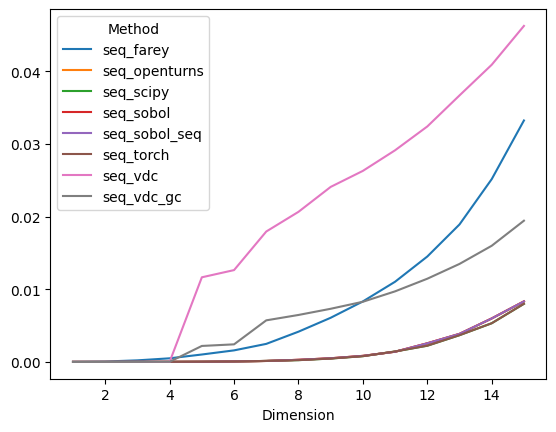

In [16]:
df_result.plot()

взять матрицу V из scipy, взять другие последовательности вместо фарея,

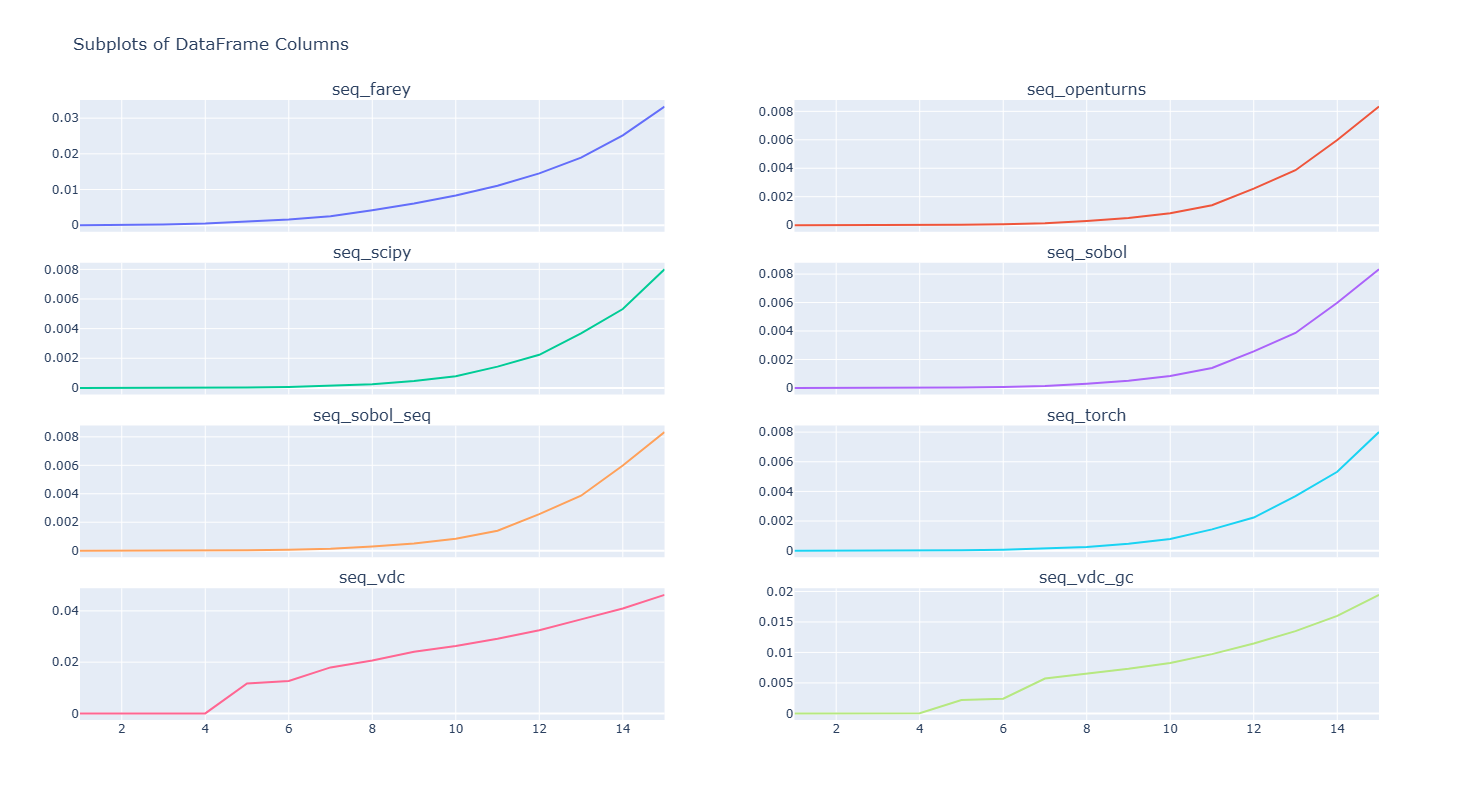

In [19]:
num_cols = 2
num_rows = (len(df_result.columns) + num_cols - 1) // num_cols  # Compute the number of rows

fig = make_subplots(rows=num_rows, cols=num_cols, shared_xaxes=True, vertical_spacing=0.05, 
                    subplot_titles=df_result.columns)

for i, col in enumerate(df_result.columns):
    row = i // num_cols + 1
    col_pos = i % num_cols + 1
    fig.add_trace(go.Scatter(x=df_result.index, y=df_result[col], mode='lines', name=col), 
                  row=row, col=col_pos)

fig.update_layout(height=800, width=800, title_text="Subplots of DataFrame Columns", showlegend=False)
fig.show()

### 2 KMC

In [31]:
import os
import nbformat
from nbconvert import PythonExporter
import nbimporter
import pandas as pd
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from tqdm import tqdm
from scipy.stats import norm

import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.subplots as sp
import numpy as np
np.random.seed(7)

In [32]:
# 1  Класс точных вычислений цен опционов
notebook_filename = 'OptionPricer.ipynb'
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)
python_exporter = PythonExporter()
python_code, _ = python_exporter.from_notebook_node(notebook_content)
exec(python_code)


# 2  Класс квази Монте Карло
notebook_filename = 'Quasi_Monte_Carlo.ipynb'
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)
python_exporter = PythonExporter()
python_code, _ = python_exporter.from_notebook_node(notebook_content)
exec(python_code)


In [33]:
class Sobol_seq:
    '''
    seq_farey - Собственная реализация. Послед Фарея
    seq_vdc - Собственная реализация
    seq_vdc_gc - Собственная реализация. Код Грея
    sobol_SciPy - SciPy  модуль qmc (Quasi-Monte Carlo)
    sobol_sobol_seq - sobol_seq
    sobol_SobolSequence - SobolSequence
    sobol_PyTorch - PyTorch  модуль quasirandom 
    sobol_openturns - openturns
    random - равномерное распределение
    '''

    def __init__(self, dim, m):
        self.dim = dim
        self.m = m
        # self.result = None
        # self.time = None
    
    def result(self, name):
        if name == 'seq_farey':
            return Modify_Sobol(dim, 1, m).get_seq('farey')
        elif name == 'seq_vdc':
            return Modify_Sobol(dim, 1, m).get_seq('vdc')
        elif name == 'seq_vdc_gc':
            return Modify_Sobol(dim, 1, m).get_seq('vdc_gc')
        elif name == 'sobol_SciPy':
            return qmc.Sobol(d=self.dim, scramble=False).random_base2(self.m+1)[1:2**self.m+1]
        elif name == 'sobol_sobol_seq':
            return sobol_seq.i4_sobol_generate(self.dim, 2**self.m)
        elif name == 'sobol_SobolSequence':
            return sobol.sample(self.dim, 2**self.m)
        elif name == 'sobol_PyTorch':
            return np.array((torch.quasirandom.SobolEngine(dimension=self.dim, scramble=False)).draw(2**self.m+1)[1:])   
        elif name == 'sobol_openturns':
            return np.array((ot.SobolSequence(self.dim)).generate(2**self.m))
        elif name == 'random':
            return np.random.uniform(low=0.0, high=1.0, size=(2**self.m, self.dim))
        else:
            raise ValueError(f"Unknown sequence name: {self.name}")

# 

### Расчет стоимости опционов и их ошибок в момент времени t=0

In [34]:
S = 95 
K = 100  
r = 0.21
sigma = 0.2  
T = 1
t = 0
B = 150
S_max = 150

dim = 10
m = 10
option_type="call"

arr = ['seq_farey', 'seq_vdc', 'seq_vdc_gc', 'sobol_SciPy', 'sobol_sobol_seq', 'sobol_SobolSequence', 'sobol_PyTorch', 'sobol_openturns', 'random']
qmc0 = Quasi_Monte_Carlo(dim, m, Sobol_seq(dim, m))

result_up_and_out_option, result_asian_option, result_european_option, result_lookback_option = [], [], [], []

for i in range(len(arr)):
    result_european_option.append(qmc0.european_option(arr[i], T, t,  K, r, sigma, S, option_type))
    result_up_and_out_option.append(qmc0.up_and_out_option(arr[i], T, t, K, r, sigma, S, B, option_type))
    result_lookback_option.append(qmc0.lookback_option(arr[i], T, t, r, sigma, S, S_max, option_type))
    # result_asian_option.append(qmc0.asian_option(arr[i], T, t, K, r, sigma, S, option_type))


pricer = OptionPricer(S, K, r, sigma, T)

result_european_option.append(pricer.black_scholes_call(t))
result_up_and_out_option.append(pricer.up_and_out_call(B, t))
result_lookback_option.append(pricer.lookback_call(S_max, t))
arr.append('exact_answer')

df = pd.DataFrame({
    'European_Option_Payoff': result_european_option,
    'Up_and_Out_Payoff': result_up_and_out_option,
    'Lookback_Option_Payoff': result_lookback_option,
    # 'Asian Option Payoff': result_asian_option
}, index=arr)

df

European_Option_Payoff  Up_and_Out_Payoff  \
seq_farey                         15.113794          11.495195   
seq_vdc                           16.264849          10.880423   
seq_vdc_gc                        16.138225          10.288681   
sobol_SciPy                       16.309514          11.065474   
sobol_sobol_seq                   15.698367          10.508367   
sobol_SobolSequence               15.698367          10.508367   
sobol_PyTorch                     16.309516          11.065476   
sobol_openturns                   15.698367          10.508367   
random                            16.769952          11.297136   
exact_answer                      16.069162          11.254618   

                     Lookback_Option_Payoff  
seq_farey                         28.298991  
seq_vdc                           28.047509  
seq_vdc_gc                        28.611801  
sobol_SciPy                       27.706403  
sobol_sobol_seq                   28.506937  
sobol_SobolSequence               28.506937  
sobol_PyTorch                     27.706401  
sobol_openturns                   28.506937  
random                            27.769721  
exact_answer                      28.328486

In [35]:
err = df - df.loc['exact_answer']
err = err.iloc[:len(err)-1]
err

European_Option_Payoff  Up_and_Out_Payoff  \
seq_farey                         -0.955368           0.240577   
seq_vdc                            0.195687          -0.374195   
seq_vdc_gc                         0.069063          -0.965937   
sobol_SciPy                        0.240352          -0.189144   
sobol_sobol_seq                   -0.370795          -0.746251   
sobol_SobolSequence               -0.370795          -0.746251   
sobol_PyTorch                      0.240354          -0.189142   
sobol_openturns                   -0.370795          -0.746251   
random                             0.700790           0.042518   

                     Lookback_Option_Payoff  
seq_farey                         -0.029495  
seq_vdc                           -0.280977  
seq_vdc_gc                         0.283315  
sobol_SciPy                       -0.622083  
sobol_sobol_seq                    0.178451  
sobol_SobolSequence                0.178451  
sobol_PyTorch                     -0.622085  
sobol_openturns                    0.178451  
random                            -0.558765

### Стоимость опционов на промежутке времени от t до T

In [36]:
m = 13
print(f'Количество точек_ n = {2**m}')

Количество точек_ n = 8192


In [39]:
S = 95 
K = 100  
r = 0.21
sigma = 0.2  
T = 1
t = 0
B = 150
S_max = 150
time_steps = np.linspace(0, T, 11, endpoint=True)  

dim = 11
m = 10
option_type = "call"

arr = ['seq_farey', 'seq_vdc', 'seq_vdc_gc', 'sobol_SciPy', 'sobol_sobol_seq', 'sobol_SobolSequence', 'sobol_PyTorch', 'sobol_openturns', 'random']

qmc0 = Quasi_Monte_Carlo(dim, m, Sobol_seq(dim, m))

from tqdm import tqdm

european_option = dict.fromkeys(arr)
up_and_out_option = dict.fromkeys(arr)
lookback_option = dict.fromkeys(arr)
asian_option = dict.fromkeys(arr)

for seq in tqdm(arr):
    result_european_option, result_up_and_out_option, result_lookback_option, result_asian_option = [], [], [], []
    for t in time_steps:
        result_european_option.append(qmc0.european_option(seq, T, t, K, r, sigma, S, option_type))
        result_up_and_out_option.append(qmc0.up_and_out_option(seq, T, t, K, r, sigma, S, B, option_type))
        result_lookback_option.append(qmc0.lookback_option(seq, T, t, r, sigma, S, S_max, option_type))
        # result_asian_option.append(qmc0.asian_option(seq, T, t, K, r, sigma, S, option_type)) # Если требуется
        
    european_option[seq] = result_european_option
    up_and_out_option[seq] = result_up_and_out_option
    lookback_option[seq] = result_lookback_option
    #asian_option[seq] = result_asian_option  



        



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:50<00:00,  5.65s/it]


In [40]:
exact_european_option, exact_up_and_out_option, exact_lookback_option =[], [], []

for t in time_steps:
    exact_european_option.append(pricer.black_scholes_call(t))
    exact_up_and_out_option.append(pricer.up_and_out_call(B, t))
    exact_lookback_option.append(pricer.lookback_call(S_max, t))

<string>:79: RuntimeWarning:

divide by zero encountered in scalar divide

<string>:81: RuntimeWarning:

divide by zero encountered in scalar divide

<string>:82: RuntimeWarning:

divide by zero encountered in scalar divide



In [41]:
df_exact_european_option = pd.DataFrame(exact_european_option).set_index(time_steps)
df_exact_up_and_out_option = pd.DataFrame(exact_up_and_out_option).set_index(time_steps)
df_exact_lookback_option = pd.DataFrame(exact_lookback_option).set_index(time_steps)

df_european_option = pd.DataFrame(european_option).set_index(time_steps)
df_up_and_out_option = pd.DataFrame(up_and_out_option).set_index(time_steps)
df_lookback_option = pd.DataFrame(lookback_option).set_index(time_steps)

df_european_option = df_european_option.join(df_exact_european_option, how='left')
df_up_and_out_option = df_up_and_out_option.join(df_exact_up_and_out_option, how='left')
df_lookback_option = df_lookback_option.join(df_exact_lookback_option, how='left')

df_european_option = df_european_option.rename(columns={0: 'exact'})
df_up_and_out_option = df_up_and_out_option.rename(columns={0: 'exact'})
df_lookback_option = df_lookback_option.rename(columns={0: 'exact'})

In [42]:
df_european_option.columns


Index(['seq_farey', 'seq_vdc', 'seq_vdc_gc', 'sobol_SciPy', 'sobol_sobol_seq',
       'sobol_SobolSequence', 'sobol_PyTorch', 'sobol_openturns', 'random',
       'exact'],
      dtype='object')

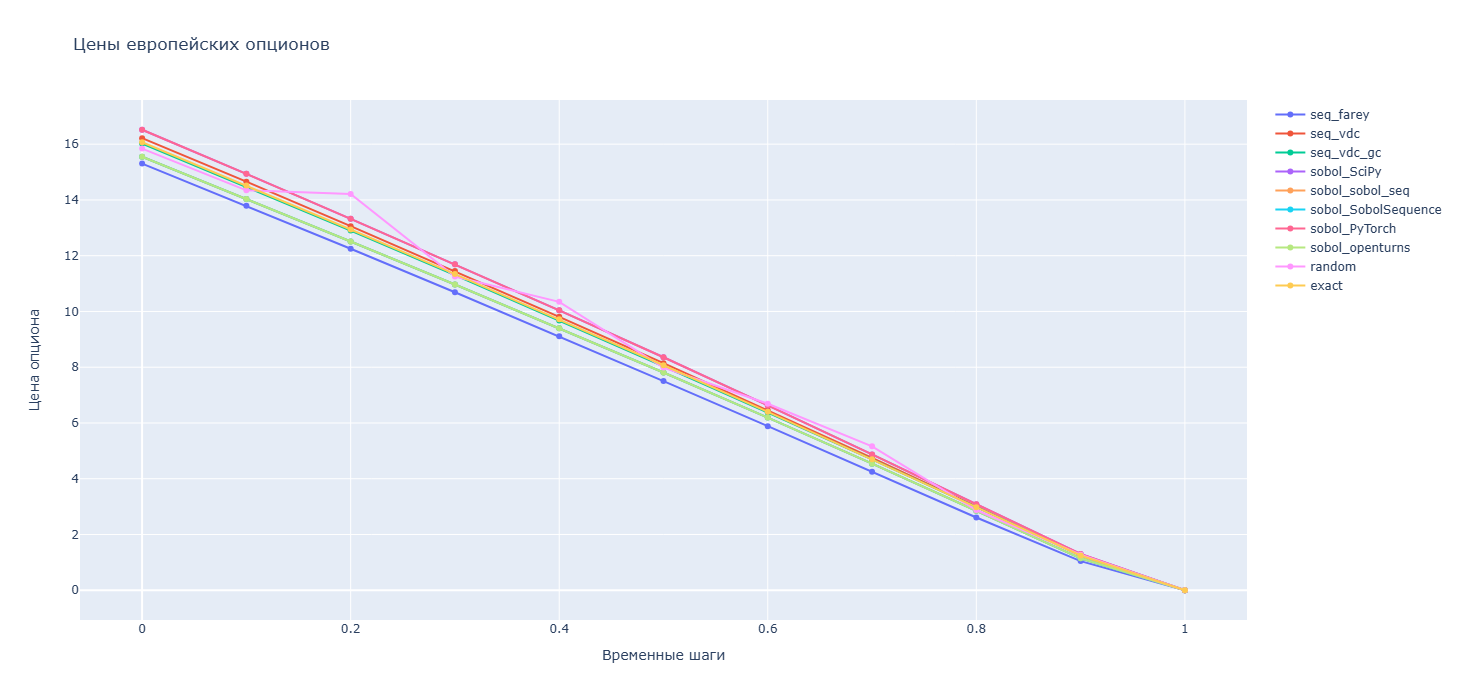

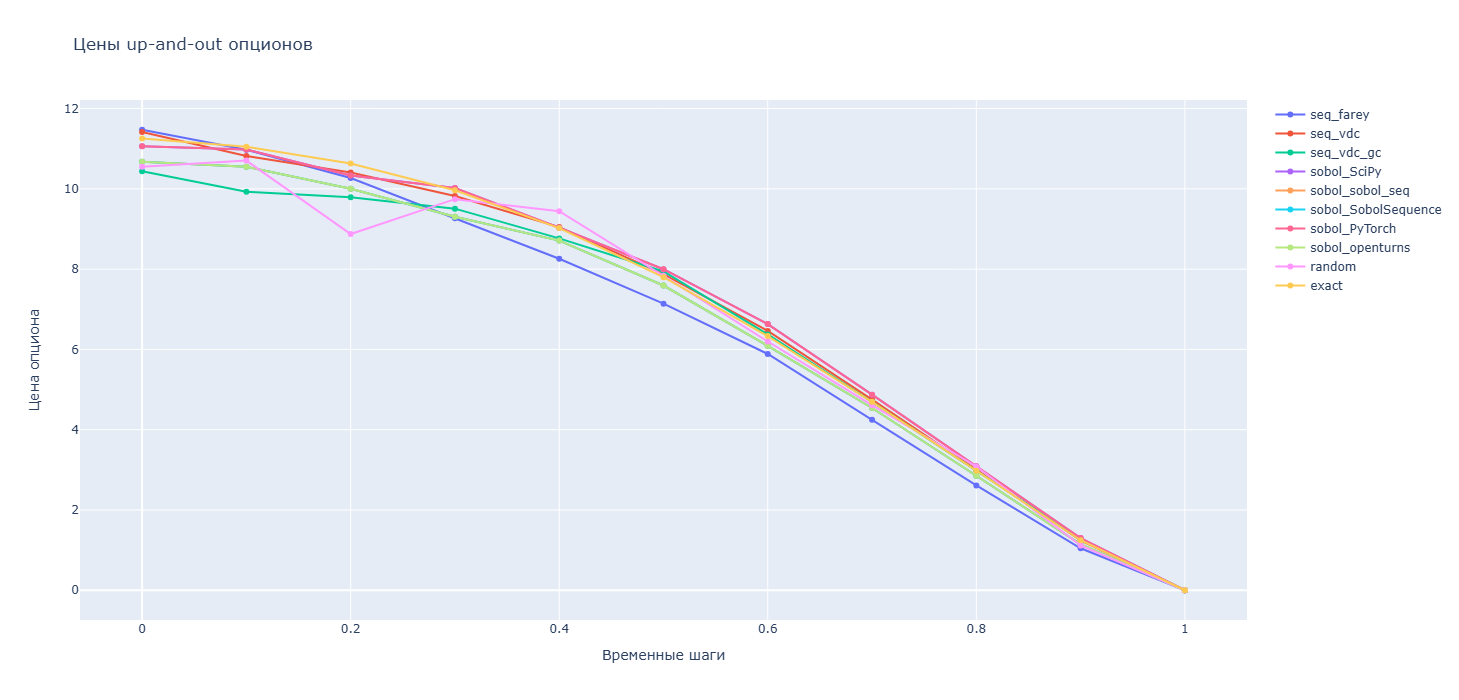

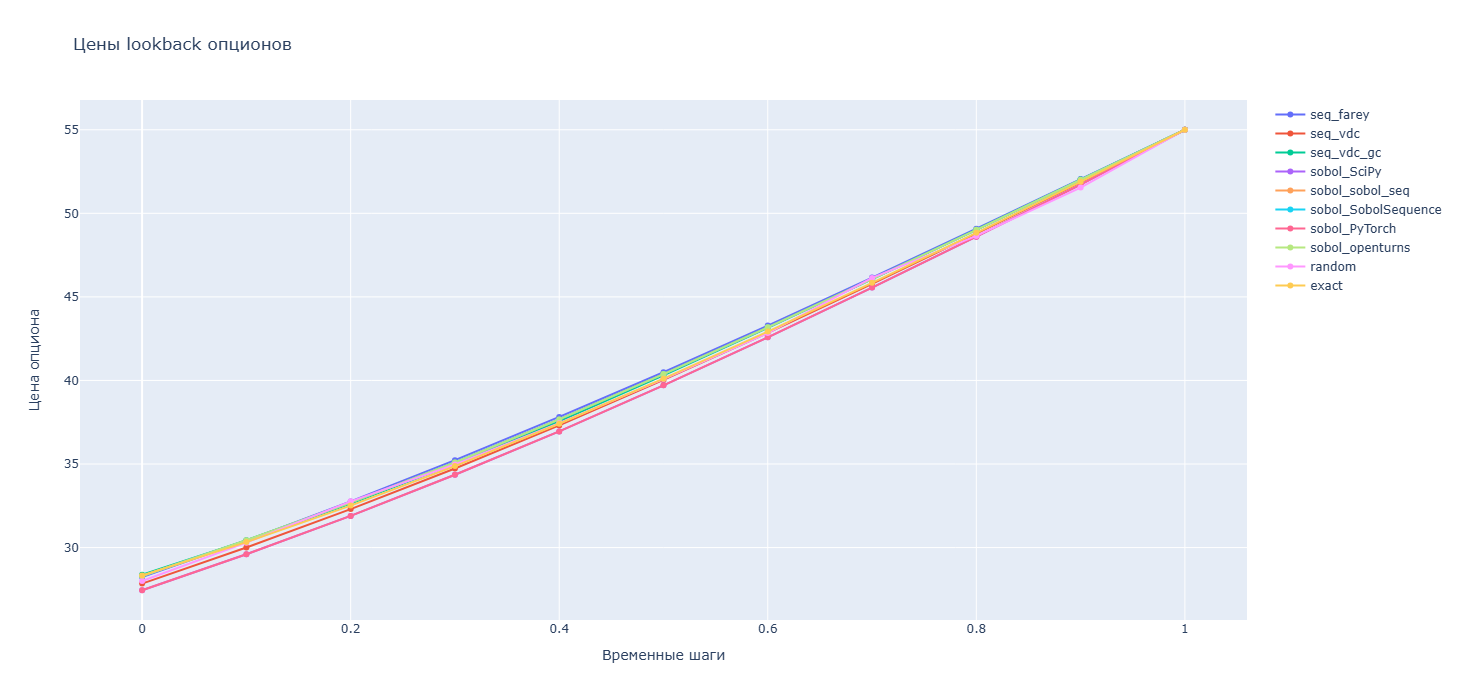

In [43]:
def plot_option(df, title, yaxis_title, width, height):
    fig = go.Figure()
    

    for col in df.columns:
        fig.add_trace(go.Scatter(x=df.index, 
                                 y=df[col], 
                                 mode='lines+markers', 
                                 name=col))

    # Настройка графика
    fig.update_layout(title=title,
                      xaxis_title='Временные шаги',
                      yaxis_title=yaxis_title,
                      template='plotly',
                      width=width,
                      height=height)
    
    return fig


fig_european_option = plot_option(df_european_option, 'Цены европейских опционов', 'Цена опциона', width=700, height=700)
fig_up_and_out_option = plot_option(df_up_and_out_option, 'Цены up-and-out опционов', 'Цена опциона', width=700, height=700)
fig_lookback_option = plot_option(df_lookback_option, 'Цены lookback опционов', 'Цена опциона', width=700, height=700)

fig_european_option.show()
fig_up_and_out_option.show()
fig_lookback_option.show()


### Ошибки стоимости опционов на промежутке времени от t до T

In [44]:
error_european_option = df_european_option.apply(lambda x: x - df_european_option['exact'], axis=0)
error_up_and_out_option = df_up_and_out_option.apply(lambda x: x - df_up_and_out_option['exact'], axis=0)
error_lookback_option = df_lookback_option.apply(lambda x: x - df_lookback_option['exact'], axis=0)


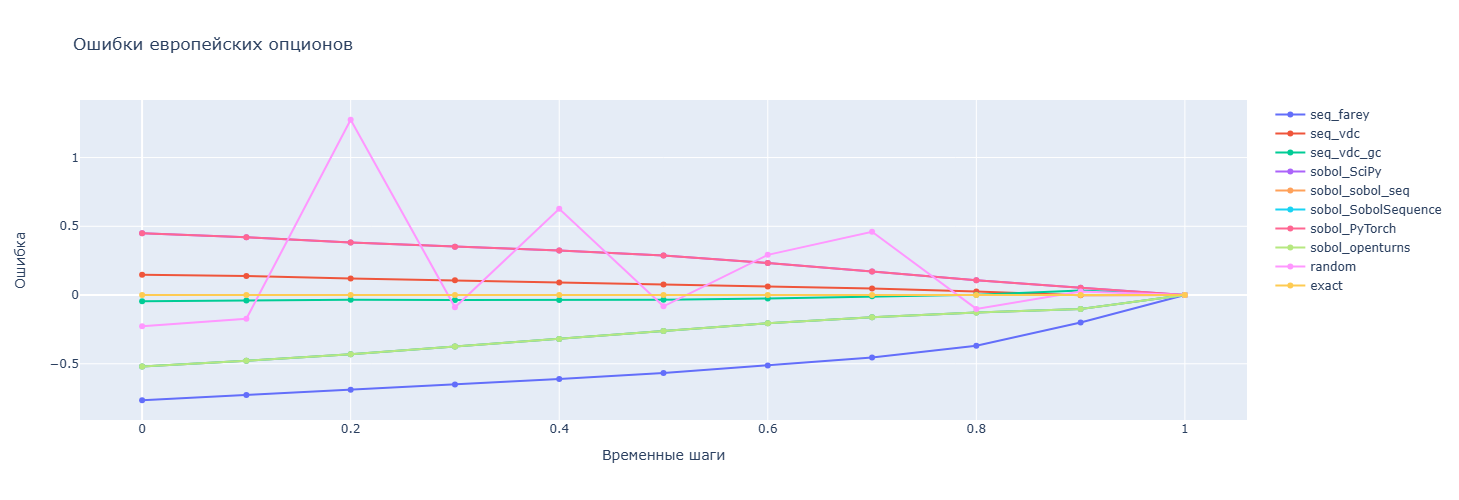

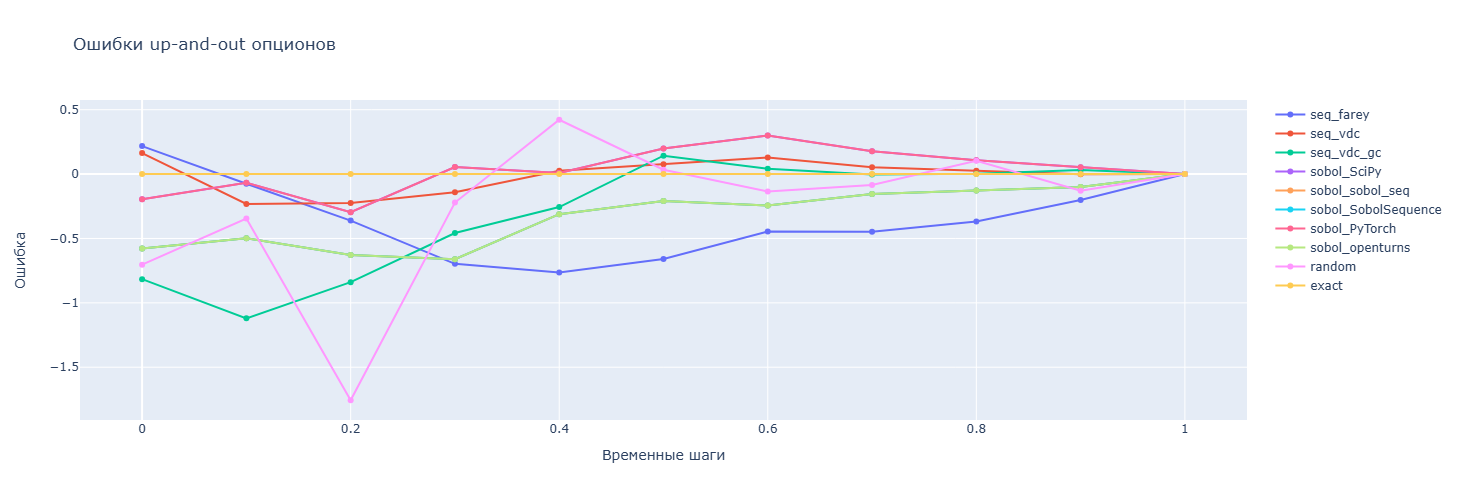

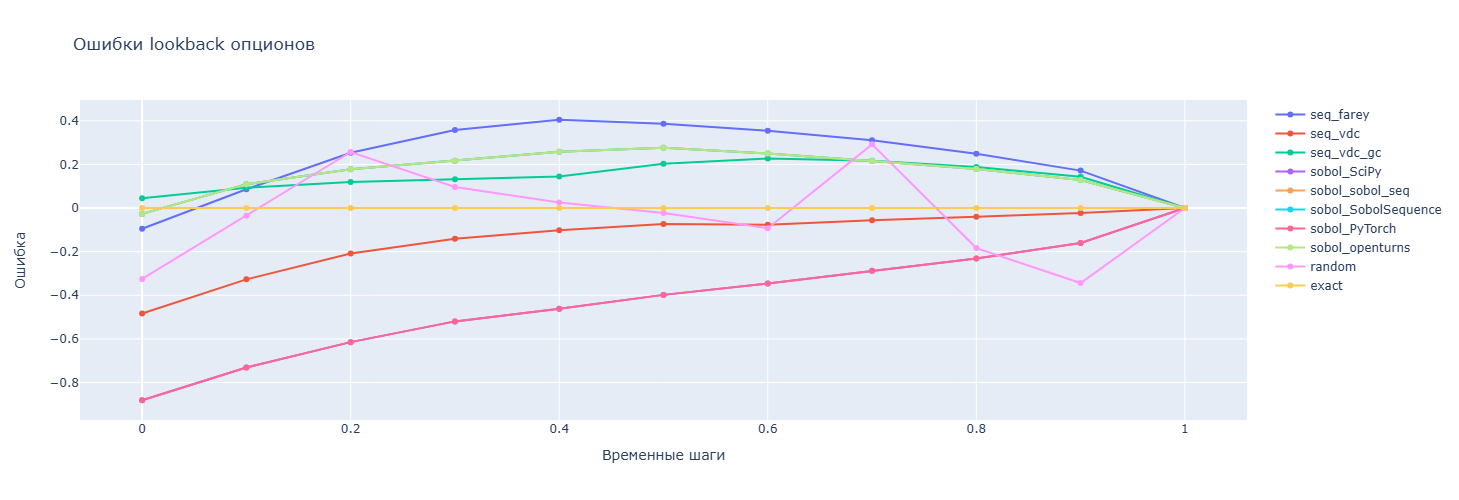

In [45]:
fig_error_european_option = plot_option(error_european_option, 'Ошибки европейских опционов', 'Ошибка', width=1000, height=500)
fig_error_up_and_out_option = plot_option(error_up_and_out_option, 'Ошибки up-and-out опционов', 'Ошибка', width=1000, height=500)
fig_error_lookback_option = plot_option(error_lookback_option, 'Ошибки lookback опционов', 'Ошибка', width=1000, height=500)

fig_error_european_option.show()
fig_error_up_and_out_option.show()
fig_error_lookback_option.show()